In [1]:
# PAQUETES PARA CORRER OP.
import pandas as pd
import numpy as np
import datetime as dt
import json
import wmf.wmf as wmf
import hydroeval
import glob
import MySQLdb
#modulo pa correr modelo
import SHop
import hidrologia

#FORMATO
# fuente
import matplotlib
matplotlib.use('Agg')
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
font_dirs = ['/home/hidrologia/jupyter/SH_op/fuentes/AvenirLTStd-Book']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'Avenir LT Std'
matplotlib.rcParams['font.size']=12
import pylab as pl 
#axes
pl.rc('axes',labelcolor='#4f4f4f')
pl.rc('axes',linewidth=1.5)
pl.rc('axes',edgecolor='#bdb9b6')
pl.rc('text',color= '#4f4f4f')
# pl.rc('xtick',color='#4f4f4f')
# pl.rc('ytick',color='#4f4f4f')
# pl.locator_params(axis='y', nbins=5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

No se logra importar basemap, por lo tanto no funciona Plot_basin


/home/socastillogi/py_env/lib/python3.8/site-packages/SHop-0.0.2-py3.8.egg/SHop/SHop_src.py:44: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [2]:
# PAQUETES A CORRER EN PLANTILLA.
import matplotlib.pylab as pl 
%matplotlib inline

### Ejecución diaria


In [3]:
date_ev = pd.to_datetime('2018-11-26 06:00')

In [4]:
############################################################################################  ARGUMENTOS
print (dt.datetime.now())

ruta_proj = '/home/socastillogi/jupyter/SH_op/SHop_E260_90m_1d/SHop/project_files/'
configfile=ruta_proj+'inputs/configfile_SHop_E260_90m_1d.md'
save_hist = False #####################################################False for first times
dateformat_starts = '%Y-%m-%d'
date = pd.to_datetime(date_ev.strftime(dateformat_starts))
ConfigList= SHop.get_rutesList(configfile)

############################################################################################ EJECUCION

ConfigList= SHop.get_rutesList(configfile)
# abrir simubasin
path_ncbasin = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc')
cu = wmf.SimuBasin(rute=path_ncbasin)

#sets para correr modelo.
SHop.set_modelsettings(ConfigList)
warming_steps =  0#pasos de simulacion, dependen del dt.
warming_window ='%ss'%int(wmf.models.dt * warming_steps) #siempre en seg
dateformat_starts = '%Y-%m-%d'

starts  = ['%ss'%(90*24*60*60)]#,'%ss'%(90*24*60*60)] #60d back
starts_names = ['90d']#,'1d'] #starts y starts_names deben ser del mismo len.
window_end = '0s' #none

print ('######')
print ('Start DAILY execution: %s'%dt.datetime.now()) 

#dates
date = (pd.to_datetime(pd.to_datetime(date).strftime('%Y-%m-%d')) - pd.Timedelta('8 day')) #llega a donde empieza el horario

starts_w = [date - pd.Timedelta(start) for start in starts]
starts_m_d = [start_w - pd.Timedelta(warming_window) for start_w in starts_w]
end_d = date + pd.Timedelta(window_end)

# df execution
df_executionprops_d = pd.DataFrame([starts,
                                  starts_names,
                                  ['/home/socastillogi/jupyter/SH_op/src/calibracion_validacion/calval_enbloque/outputs/bin_sto/SMsim_d_2018-202008.StOhdr'],
                                    #iniciar desde las CI del bin de mediano plazo
#                                   '%s-p01-ci1-90d.StOhdr'%(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_sto_op'))], #first run: 0.0,
                                  ['ci1'],
                                  [[1.0 , 5.9 , 5.7 , 0.0 , 1.0 , 1.0 , 10.8 , 1.0 , 1.0 , 1.0, 1.0 ]],
                                  ['-p01'],
                                  [0]], #wup_stets:pasos de sim, depende de dt #int((end - starts_w[0]).total_seconds()/wmf.models.dt)
                                 columns = [1],
                                 index = ['starts','start_names','CIs','CI_names','pars','pars_names','wup_steps']).T

#rainfall
pseries,ruta_out_rain_d = SHop.get_rainfall2sim(ConfigList,cu,path_ncbasin,[starts_m_d[0]],end_d, #se corre el bin mas largo.
                                             Dt= float(wmf.models.dt),include_escenarios=None,
                                             evs_hist= False,
                                             check_file=True,stepback_start = '%ss'%int(wmf.models.dt *1),
                                             complete_naninaccum=True,verbose=False)

print (ruta_out_rain_d)

#consulta x,y estaciones de humedad.
server,user,passwd,dbname = SHop.get_credentials(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_credenciales'))
df_xy_est = hidrologia.bd.sql_query('select codigo,longitude,latitude from estaciones where red in ("humedad","humedad_stevens","humedad_laderas_5te_rasp","humedad_stevens_laderas_rasp") and estado in ("A","P")',
                                 server,user,passwd,dbname)
#coordenadas to numeric
df_xy_est = df_xy_est.apply(pd.to_numeric, errors='ignore')
df_xy_estH = df_xy_est.set_index('codigo')

# set of executions
ListEjecs_d = SHop.get_executionlists_fromdf(ConfigList,ruta_out_rain_d,cu,starts_m_d,end_d,df_executionprops_d,
                                             df_xy_estH,
                                             warming_steps=warming_steps, dateformat_starts = dateformat_starts,
                                             fecha_binsto = starts_m_d[0])

#execution
print ('Start simulations: %s'%dt.datetime.now())
print ('start: %s - end: %s'%(starts_m_d[0], end_d))
res = SHop.get_qsim(ListEjecs_d,set_CI=True,save_hist=save_hist,verbose = True)
print ('End simulations: %s'%dt.datetime.now())

2021-03-08 19:29:28.955460
######
Start DAILY execution: 2021-03-08 19:29:29.067757
.bin & .hdr saved
/home/socastillogi/jupyter/SH_op/SHop_E260_90m_1d/SHop/project_files/results/results_op/rain_op/201808190000_201811180000-SHop_E260_90m_1d.bin
SERVER_CON: Succesful connection to Sal
Start simulations: 2021-03-08 19:59:01.868586
start: 2018-08-20 00:00:00 - end: 2018-11-18 00:00:00
Config. -p01ci1-/home/socastillogi/jupyter/SH_op/SHop_E260_90m_1d/SHop/project_files/results/results_h/Qsim_hist-p01-ci1-90d.csv ejecutado
End simulations: 2021-03-08 19:59:03.840537


<AxesSubplot:xlabel=' Fecha '>

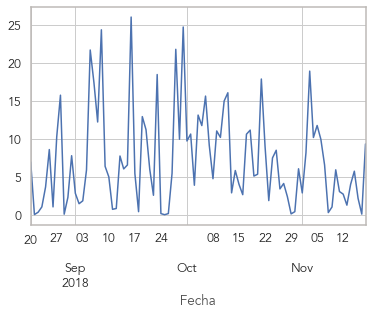

In [5]:
df_st = wmf.read_rain_struct(ruta_out_rain_d.split('.')[0]+'.hdr')
df_st[' Lluvia'].plot()

In [6]:
print('execution takes: %s seg.'%(30*60.))

execution takes: 1800.0 seg.


---

#### Revisar
- revisar los intermedios y que se actualicen correctamente los archivo historicos.

In [48]:
ruta_out_rain_d

'/home/socastillogi/jupyter/SH_op/SHop_E260_90m_1d/SHop/project_files/results/results_op/rain_op/201808190000_201811180000-SHop_E260_90m_1d.bin'

In [49]:
p = wmf.read_rain_struct(ruta_out_rain_d.split('.')[0]+'.hdr')

<AxesSubplot:xlabel=' Fecha '>

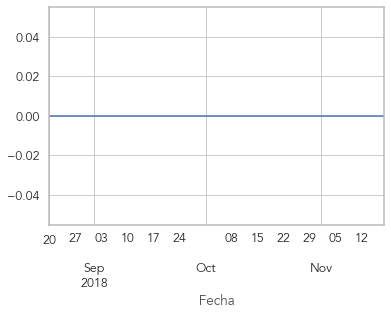

In [50]:
p[' Lluvia'].plot()

In [5]:
#REVISAR CAUDAL.
#tramos, para sacar los datos del modelo.
df_tramos = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc_tramos'),index_col=0)
ests = df_tramos.index
#curvas que escogí.
df_est_features = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_curvascalob3'),index_col=0)
ests = df_est_features.index
tramos_ids = np.concatenate(df_tramos.loc[ests].values)
df_est_features['tramo'] = list(map(str,tramos_ids))

In [7]:
ListEjecs_d

[[<wmf.wmf.SimuBasin at 0x7ff6771bea60>,
  'ci1',
  array([[2.8050000e+02, 2.8050000e+02, 2.8050000e+02, ..., 4.1489999e+02,
          4.1489999e+02, 4.8591667e+01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00],
         [1.2891123e+00, 8.4649920e-01, 3.1415772e-01, ..., 4.3120492e-01,
          8.7539506e-01, 4.1846158e+02],
         [3.1673691e+01, 2.8855221e+01, 2.7446735e+01, ..., 1.8915449e+01,
          2.8331781e+01, 1.7210945e+03],
         [5.0000004e-03, 5.0000004e-03, 5.0000004e-03, ..., 5.0000004e-03,
          5.0000004e-03, 1.6125000e+01]], dtype=float32),
  '/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1d/SHop/project_files/results/results_op/rain_op/202007280000_202010270000-SHop_E260_90m_1d.bin',
  '-p01',
  [1.0, 5.9, 5.7, 0.0, 1.0, 1.0, 10.8, 1.0, 1.0, 1.0, 1.0],
  91,
  0,
  '90d',
  '/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1d/SHop/project_files/results/results_op/Sto_op-p01-ci1-90d',
  '/hom

- MS_sim H

<AxesSubplot:xlabel='fecha'>

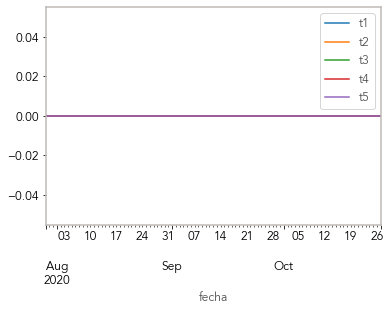

In [12]:
path_ms_sim= '%s-p01-ci1-90d.csv'%(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_MS_hist'))

dflol = pd.read_csv(path_ms_sim,index_col=0,parse_dates=True)

dflol['2020-06':].plot()

- Qsim H

In [13]:
path_ms_sim= '%s-p01-ci1-90d.csv'%(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_qsim_hist'))
dflol = pd.read_csv(path_ms_sim,index_col=0,parse_dates=True)

<AxesSubplot:>

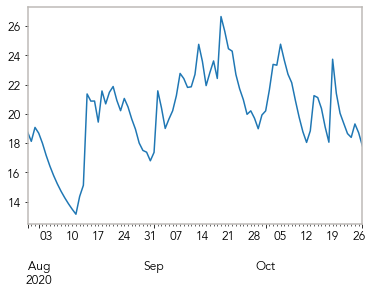

In [14]:
est = 99
dflol['2020-06':]['%s'%(df_est_features.tramo.loc[est])].plot()

- Qsim OP

In [15]:
path_Q_sim= '%s-p01-ci1-90d.csv'%(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_qsim_op'))
dflol = pd.read_csv(path_Q_sim,index_col=0,parse_dates=True)

<AxesSubplot:>

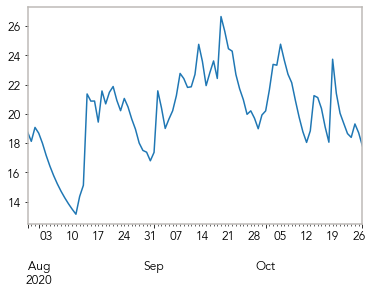

In [16]:
est = 99
dflol['2020-06':]['%s'%(df_est_features.tramo.loc[est])].plot()

In [17]:
dflol.index

DatetimeIndex(['2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02',
               '2020-09-03', '2020-09-04', '2020-09-05', '2020-09-06',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14',
               '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18',
               '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22',
      

#### Revisar binhumedad.

In [14]:
f=open(ListEjecs_d[0][-5]+'.StOhdr')
filelines=f.readlines()
f.close()
IDs=np.array([int(i.split(',')[0]) for i in filelines[5:]])

In [15]:
v,r = wmf.models.read_float_basin_ncol(ListEjecs_d[0][-5]+'.StObin',100, cu.ncells, 5)

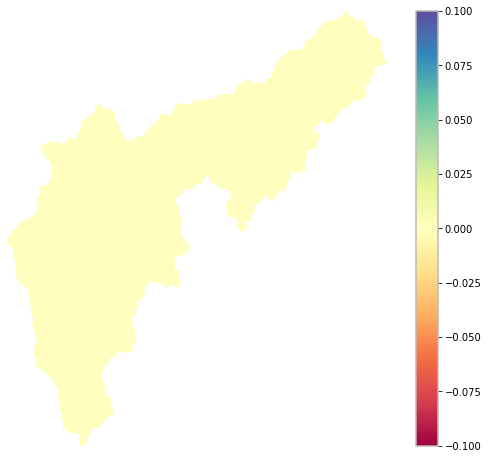

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [16]:
cu.Plot_basinClean(v[0]/wmf.models.max_capilar,show_cbar=True)

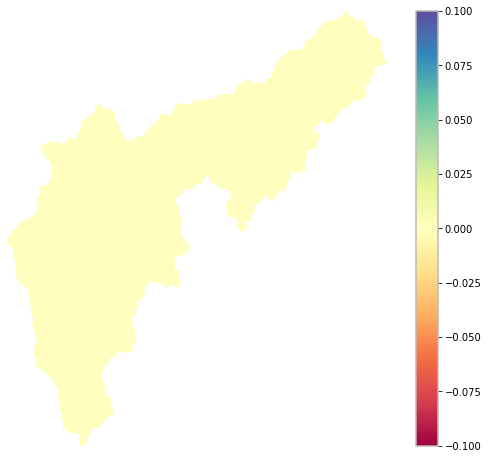

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [17]:
cu.Plot_basinClean(v[2]/wmf.models.max_capilar,show_cbar=True)

-----

-----

-----

3. reciclar unas min. 4 veces la simulación: cambiar la ci en el dataframe.
4. ahí sí cronear.